# Section 2: Running Causal Forests on GSS data

In [32]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.model_selection import train_test_split
from econml.dml import CausalForestDML

import warnings
warnings.filterwarnings("ignore")

## Loading and Cleaning data

In [2]:
# w = 0 means the question had "assistance", w = 1 means the question had "welfare"
# y = 0 means the responder said no, y = 1 means yes
welfare_raw = pd.read_csv("welfarelabel.csv", low_memory=False)
labels = welfare_raw['y'].values
treatments = welfare_raw['w']
treatments = treatments.replace({0:1, 1:0}) # we want 1 to be assistance, and 0 to be welfare, so if the TE is positive then it means people responded favorably to assistance
welfare_raw.drop(columns=["_merge", 'y', 'id', 'w'], inplace=True)
welfare_raw

,year,wrkstat,hrs1,hrs2,evwork,occ,prestige,wrkslf,wrkgovt,commute,...,preteen_miss,teens_miss,adults_miss,unrelat_miss,earnrs_miss,income_miss,rincome_miss,income86_miss,partyid_miss,polviews_miss
0,1986,working fulltime,40.000000,38.613701,1.1395408,270.00000,44.000000,someone else,private,60,...,0,0,0,0,0,0,0,0,0,0
1,1986,keeping house,41.733318,38.613701,1,195.00000,51.000000,someone else,private,10,...,0,0,0,1,0,0,1,0,0,0
2,1986,working fulltime,40.000000,38.613701,1.1395408,184.00000,51.000000,someone else,private,35,...,0,0,0,1,0,0,0,0,0,0
3,1986,retired,41.733318,38.613701,1,311.00000,36.000000,someone else,1,25,...,0,0,0,0,0,0,1,0,0,0
4,1986,working parttime,41.733318,38.613701,1.1395408,449.41599,40.335918,someone else,1.8203658,25,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36496,2010,retired,41.733318,38.613701,1,449.41599,40.335918,someone else,private,20.245865,...,0,0,0,0,0,0,1,1,0,0
36497,2010,retired,41.733318,38.613701,1,449.41599,40.335918,someone else,private,20.245865,...,0,0,0,0,0,0,1,1,0,0
36498,2010,working fulltime,40.000000,38.613701,1.1395408,449.41599,40.335918,someone else,private,20.245865,...,0,0,0,1,0,0,0,1,0,0
36499,2010,working fulltime,49.000000,38.613701,1.1395408,449.41599,40.335918,someone else,private,20.245865,...,0,0,0,1,0,0,1,1,0,0


In [4]:
def cleanWelfare(welfare_raw):
    welfare = welfare_raw.copy()

    toClean = set(['commute', 'childs', 'age', 'preteen', 'adults', 'unrelat', 'earnrs'])
    toEncode = set(['year', 'occ'])

    encoders = {} # want a dictionary to keep track of columns and their encoded values so can decode when done

    for column in welfare:
        if '_' not in column:
            if column in toEncode:
                le = LabelEncoder()
                le.fit(welfare[column])
                welfare[column] = le.transform(welfare[column])
                encoders[column] = le 
            elif column in toClean:
                if column == 'commute':
                    welfare[column] = pd.to_numeric(welfare[column].apply(lambda x: 97 if x == '97+ minutes' else x), errors='coerce')
                elif column == 'childs' or column == 'earnrs':
                    welfare[column] = pd.to_numeric(welfare[column].apply(lambda x: 8 if x == 'eight or more' else x), errors='coerce')
                elif column == 'age':
                    welfare[column] = pd.to_numeric(welfare[column].apply(lambda x: 89 if x == '89 or older' else x), errors='coerce')
                elif column == 'preteen' or column == 'adults' or column =='unrelat':
                    welfare[column] = pd.to_numeric(welfare[column].apply(lambda x: 8 if x == '8 or more' else x), errors='coerce')
                else:
                    continue # should never reach here
                welfare[column] = normalize(welfare[column].values.reshape(1, -1))[0] # once column converted to float, normalize
            else:
                if welfare[column].dtype == welfare['teens'].dtype: # float64 column
                    welfare[column] = normalize(welfare[column].values.reshape(1, -1))[0]
                elif welfare[column].dtype == welfare['polviews'].dtype: # object column
                    le = LabelEncoder()
                    le.fit(welfare[column])
                    welfare[column] = le.transform(welfare[column])
                    encoders[column] = le 
                else:
                    continue # should never reach here
    return welfare, encoders

welfare, encoders = cleanWelfare(welfare_raw)
welfare

,year,wrkstat,hrs1,hrs2,evwork,occ,prestige,wrkslf,wrkgovt,commute,...,preteen_miss,teens_miss,adults_miss,unrelat_miss,earnrs_miss,income_miss,rincome_miss,income86_miss,partyid_miss,polviews_miss
0,0,7,0.004845,0.005228,1,135,0.005641,2,2,0.015315,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0.005055,0.005228,0,106,0.006538,2,2,0.002552,...,0,0,0,1,0,0,1,0,0,0
2,0,7,0.004845,0.005228,1,99,0.006538,2,2,0.008934,...,0,0,0,1,0,0,0,0,0,0
3,0,3,0.005055,0.005228,0,142,0.004615,2,0,0.006381,...,0,0,0,0,0,0,1,0,0,0
4,0,8,0.005055,0.005228,1,211,0.005171,2,1,0.006381,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36496,15,3,0.005055,0.005228,0,211,0.005171,2,2,0.005168,...,0,0,0,0,0,0,1,1,0,0
36497,15,3,0.005055,0.005228,0,211,0.005171,2,2,0.005168,...,0,0,0,0,0,0,1,1,0,0
36498,15,7,0.004845,0.005228,1,211,0.005171,2,2,0.005168,...,0,0,0,1,0,0,0,1,0,0
36499,15,7,0.005935,0.005228,1,211,0.005171,2,2,0.005168,...,0,0,0,1,0,0,1,1,0,0


## Estimating ATE and its CI

In [5]:
def estimate_cf(y, X, treatments, test_size=0.2, criterion='mse', cv=5):
    # split data into train and test sets 
    X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, y, treatments, test_size=test_size)
        
    # specify hyperparams of model
    est = CausalForestDML(criterion='het', 
                            n_estimators=1000,       
                            min_samples_leaf=10, 
                            max_depth=None, 
                            max_samples=0.5,
                            discrete_treatment=True,
                            honest=True,
                            inference=True,
                            cv=cv,
                            )
    # fit model
    est.fit(Y_train, T_train, X=X_train, W=None)
        
    return est, X_test

In [6]:
est_general, X_test_general = estimate_cf(labels, welfare, treatments)
est_general.ate_inference(X_test_general)

In [46]:
general_lb, general_ub = est_general.ate_interval(X_test_general, alpha=0.05)

print("The test ATE is equal to:", est_general.ate(X_test_general))
print("With a 95% confidence interval of (" + str(general_lb) + ", " + str(general_ub) + ")")

The test ATE is equal to: 0.32836531136333486
With a 95% confidence interval of (0.2685932333349746, 0.38813738939169506)


## CATES

In [11]:
# Create a model to fit on full data to get CATE estimates for future sections
est_full = CausalForestDML(criterion='het', 
                            n_estimators=1000,       
                            min_samples_leaf=10, 
                            max_depth=None, 
                            max_samples=0.5,
                            discrete_treatment=True,
                            honest=True,
                            inference=True,
                            cv=5
                            )
                                
est_full.fit(labels, treatments, X=welfare, W=None)
print("Done fitting")

### CATES for Party Identification

In [7]:
# view all partyid types
welfare_raw['partyid'].value_counts()

not str democrat      7093
not str republican    5969
independent           5859
strong democrat       5666
ind,near dem          4110
strong republican     3880
ind,near rep          3196
other party            512
2.8216343              216
Name: partyid, dtype: int64

In [8]:
# view the corresponding numerical encodings for the cleaned data
welfare['partyid'].value_counts()

4    7093
5    5969
3    5859
7    5666
1    4110
8    3880
2    3196
6     512
0     216
Name: partyid, dtype: int64

In [9]:
notStrongDem = welfare.loc[welfare['partyid'] == 4]
notStrongRep = welfare.loc[welfare['partyid'] == 5]
strongDem = welfare.loc[welfare['partyid'] == 7]
strongRep = welfare.loc[welfare['partyid'] == 8]
nearDem = welfare.loc[welfare['partyid'] == 1]
nearRep = welfare.loc[welfare['partyid'] == 2]
independent = welfare.loc[welfare['partyid'] == 3]

In [47]:
notStrongDem_CATE = est_general.ate(notStrongDem)
notStrongDem_lb, notStrongDem_ub = est_general.ate_interval(notStrongDem, alpha=0.05)

notStrongRep_CATE = est_general.ate(notStrongRep)
notStrongRep_lb, notStrongRep_ub = est_general.ate_interval(notStrongRep, alpha=0.05)

strongDem_CATE = est_general.ate(strongDem)
strongDem_lb, strongDem_ub = est_general.ate_interval(strongDem, alpha=0.05)

strongRep_CATE = est_general.ate(strongRep)
strongRep_lb, strongRep_ub = est_general.ate_interval(strongRep, alpha=0.05)

nearDem_CATE = est_general.ate(nearDem)
nearDem_lb, nearDem_ub = est_general.ate_interval(nearDem, alpha=0.05)

nearRep_CATE = est_general.ate(nearRep)
nearRep_lb, nearRep_ub = est_general.ate_interval(nearRep, alpha=0.05)

independent_CATE = est_general.ate(independent)
independent_lb, independent_ub = est_general.ate_interval(independent, alpha=0.05)

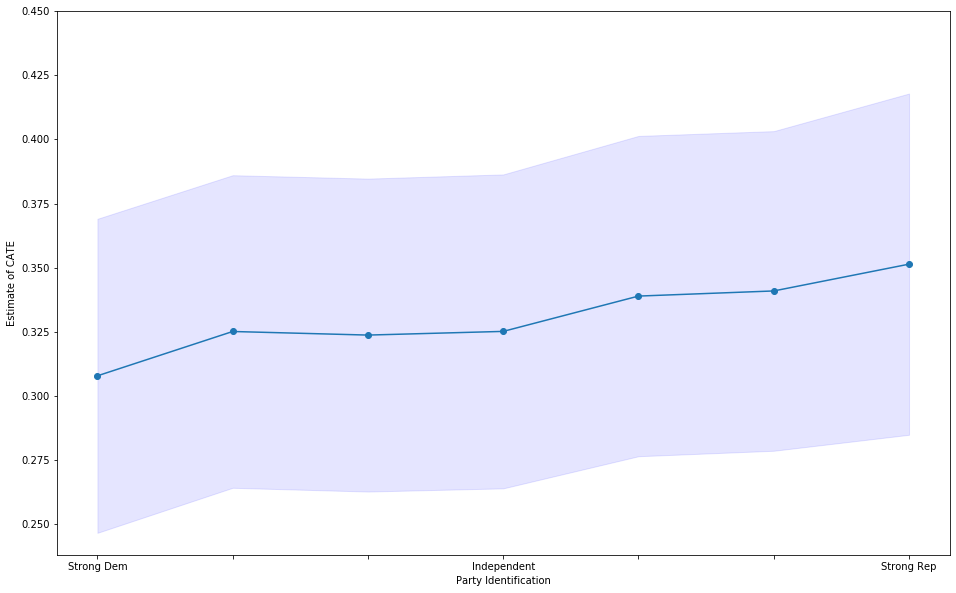

In [48]:
partyid_xs = ['Strong Dem', 'Weak Dem', 'Dem Lean', 'Ind', 'Rep Lean', 'Weak Rep', 'Rep']
partyid_ys = [strongDem_CATE, notStrongDem_CATE, nearDem_CATE, independent_CATE, nearRep_CATE, notStrongRep_CATE, strongRep_CATE]
partyid_lbs = [strongDem_lb, notStrongDem_lb, nearDem_lb, independent_lb, nearRep_lb, notStrongRep_lb, strongRep_lb]
partyid_ubs = [strongDem_ub, notStrongDem_ub, nearDem_ub, independent_ub, nearRep_ub, notStrongRep_ub, strongRep_ub]

plt.figure(figsize=(16,10))
plt.xlabel("Party Identification")
plt.ylabel("Estimate of CATE")
plt.plot(partyid_xs, partyid_ys, marker='o')
plt.fill_between(partyid_xs, partyid_lbs, partyid_ubs, color='b', alpha=.1)
plt.xticks(np.arange(7), ["Strong Dem", "", "", "Independent", "", "", "Strong Rep"])
plt.ylim(top=0.45)
plt.show()

### CATES for Political Views

In [40]:
# view all polviews types
welfare_raw['polviews'].value_counts()

moderate                12257
slghtly conservative     5053
conservative             5016
4.1220088                4405
slightly liberal         4008
liberal                  3777
extrmly conservative     1058
extremely liberal         927
Name: polviews, dtype: int64

In [41]:
# view the corresponding numerical encodings for the cleaned data
welfare['polviews'].value_counts()

5    12257
6     5053
1     5016
0     4405
7     4008
4     3777
3     1058
2      927
Name: polviews, dtype: int64

In [42]:
extremeLib = welfare.loc[welfare['polviews'] == 2]
extremeCon = welfare.loc[welfare['polviews'] == 3]
liberal = welfare.loc[welfare['polviews'] == 4]
conservative = welfare.loc[welfare['polviews'] == 1]
slightLib = welfare.loc[welfare['polviews'] == 7]
slightCon = welfare.loc[welfare['polviews'] == 6]
moderate = welfare.loc[welfare['polviews'] == 5]

In [49]:
extremeLib_CATE = est_general.ate(extremeLib)
extremeLib_lb, extremeLib_ub = est_general.ate_interval(extremeLib, alpha=0.05)

extremeCon_CATE = est_general.ate(extremeCon)
extremeCon_lb, extremeCon_ub = est_general.ate_interval(extremeCon, alpha=0.05)

liberal_CATE = est_general.ate(liberal)
liberal_lb, liberal_ub = est_general.ate_interval(liberal, alpha=0.05)

conservative_CATE = est_general.ate(conservative)
conservative_lb, conservative_ub = est_general.ate_interval(conservative, alpha=0.05)

slightLib_CATE = est_general.ate(slightLib)
slightLib_lb, slightLib_ub = est_general.ate_interval(slightLib, alpha=0.05)

slightCon_CATE = est_general.ate(slightCon)
slightCon_lb, slightCon_ub = est_general.ate_interval(slightCon, alpha=0.05)

moderate_CATE = est_general.ate(moderate)
moderate_lb, moderate_ub = est_general.ate_interval(moderate, alpha=0.05)

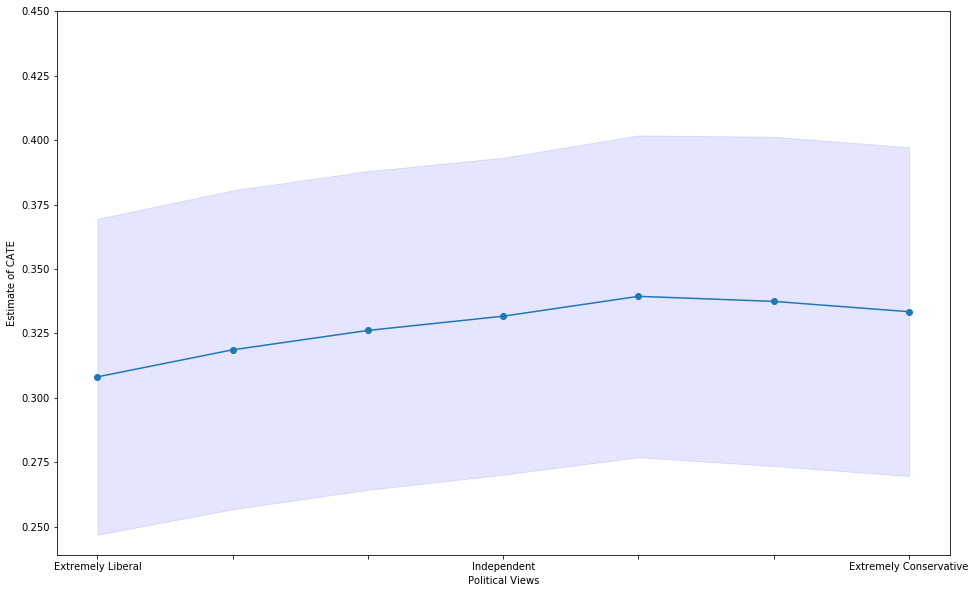

In [50]:
polview_xs = ['Extremely lib', 'Lib', 'Slight lib', 'Moderate', 'Slight con', 'Con', 'Extremely con']
polview_ys = [extremeLib_CATE, liberal_CATE, slightLib_CATE, moderate_CATE, slightCon_CATE, conservative_CATE, extremeCon_CATE]
polview_lbs = [extremeLib_lb, liberal_lb, slightLib_lb, moderate_lb, slightCon_lb, conservative_lb, extremeCon_lb]
polview_ubs = [extremeLib_ub, liberal_ub, slightLib_ub, moderate_ub, slightCon_ub, conservative_ub, extremeCon_ub]

plt.figure(figsize=(16,10))
plt.xlabel("Political Views")
plt.ylabel("Estimate of CATE")
plt.plot(polview_xs, polview_ys, marker='o')
plt.fill_between(polview_xs, polview_lbs, polview_ubs, color='b', alpha=.1)
plt.xticks(np.arange(7), ["Extremely Liberal", "", "", "Independent", "", "", "Extremely Conservative"])
plt.ylim(top=0.45)
plt.show()

### CATES for Age